# Tutorial notebook for the UVWindow module

In this notebook, we present how to use the `UVWindow` module, which provides routines to compute exact window functions for a given set of baseline lengths, with relative weights, on a given frequency range.

The theoretical background detailling the definition and computation of these window functions can be found in a memo. We only give a short summary here.

There are two classes included in the `uvwindow.py` script.
* `FTBeam`, which is used to compute and access the Fourier transform of the flat-sky approximation of the HERA beam for a given range of frequencies and a given polarisation. It is used internally by `UVWindow`. For now, its value is read from files but a computation from scratch will soon be supported.
* `UVWindow`, which computes the exact window functions given a set of baseline lengths, a pair of polarisations, and a spectral window.

The "Fourier transform of the beam" corresponds to, for $A(\theta,\nu)$ the HERA beam at angular direction $\theta$ and frequency $\nu$, for a given polarisation:
\begin{equation} 
\tilde{A}(\mathbf{q}_\perp,\nu) =  \int \mathrm{d}^2 \theta~ A(\mathbf{\theta,\nu}) ~\mathrm{e}^{-2i\pi \mathbf{\theta} \cdot \mathbf{q}_\perp}
\end{equation}
where the Fourier dual of $\theta$ is
\begin{equation}
\mathbf{q}_\perp \equiv\frac{\nu}{c}\mathbf{b}- \frac{d_c(z)}{2\pi }  \mathbf{k_\perp},
\end{equation}
for $\mathbf{b}$ the baseline length, and $d_c(z)$ the comoving distance to redshift $z(\nu)$.

The cylindrical window fuctions obtained with the module are arrays giving the mapping between instrument space $(b,\tau)$ and cosmological space $(k_\perp,k_\parallel)$. They can be spherically averaged to obtain the spherical window functions.

Then each estimated bandpower $\hat{P}$ at a given $(b,\tau)$ is an integral of the true, cosmological, power spectrum, with the window functions as weights:
\begin{equation}
\hat{P}(b,\tau)=\int \mathrm{d}k_\parallel~\mathrm{d}k_\perp~W(b,\tau,k_\perp,k_\parallel) P(k_\perp,k_\parallel).
\end{equation}

## Setting up the environment

Import necessary modules

In [1]:
from pyuvdata import UVData, UVBeam
from pyuvdata import  utils as uvutils
import hera_pspec as hp
from hera_pspec.data import DATA_PATH
from hera_cal import redcal
from  hera_pspec import utils
from hera_pspec import uvpspec_utils as uvputils

In [2]:
from astropy.io import fits
from astropy import units
from scipy.interpolate import interp2d, interp1d
from scipy import integrate
import sys, matplotlib, os, h5py
import numpy as np
from itertools import product, combinations
from astropy import units
from multiprocessing import Pool
import time, h5py
import matplotlib.pyplot as plt
from matplotlib import colors, cm
%matplotlib inline

In [3]:
from hera_pspec import UVWindow, FTBeam

In [4]:
%load_ext autoreload
%autoreload 2

Define global parameters

In [5]:
cosmo = hp.conversions.Cosmo_Conversions()
little_h = True

In [7]:
# Data files to use in tests
dfile = 'zen.2458116.31939.HH.uvh5'
ftfile = os.path.join(DATA_PATH, 'FT_beam_HERA_dipole_test_xx.hdf5')
base_ftfile = os.path.join(DATA_PATH, 'FT_beam_HERA_dipole_test')
outfile = os.path.join(DATA_PATH, 'test.hdf5')

Define the bins used for the spherical window functions. They must be an `astropy` quantity with appropriate units.

In [8]:
kmax, dk = 1., 0.128/2
krange = np.arange(dk*1.5,kmax,step=dk)
nbinsk = krange.size -1
kbins = (krange[1:]+krange[:-1])/2
kbins *= units.h / units.Mpc

Let us extract baseline lengths from a data file. We will then compute window functions for these baselines.

In [9]:
uvd = UVData()
uvd.read_uvh5(os.path.join(DATA_PATH, dfile), read_data=False)

In [10]:
reds, lens, angs = utils.get_reds(uvd,bl_error_tol=1.0,pick_data_ants=False)

Choose baseline groups used to comput the window functions.

In [11]:
bl_lens = [lens[3]]
print(bl_lens)

[25.305230165777832]


## Compute the window functions: Basic usage

The derivation of the window function relies on Fourier transforms performed on the beam of the instrument. The spatial Fourier transforms of the flat-sky-approximated beam have been pre-computed and an example file (called `ftfile` below) is available in `hera_pspec/data/`. This file corresponds to the beam for the `xx` polarisation and a reduced spectral window to save disk space.

In [12]:
spw_range = (5,25)
pol = 'xx'

### 1. Initialise  `FTBeam` object

The `FTBeam` object takes several different inputs:
* A 3D array `data` containing the real part of the Fourier transform of the beam in the sky plane (flat-sky approximation), for a set of frequencies given by `freq_array`.
* A polarisation channel (e.g., 'xx', can also be a polarisation integer).
* The spectral window `freq_array` corresponding to `data`, given as a list (or 1d array) of frequencies in Hz.
* The parameter `mapsize`, corresponding to the size of the flat map the beam was projected onto (in deg)
* The orientation in cardinal direction east or north of X dipole, given in `x_orientation`.

The inputs (esp. `data` and `freq_array`) should be chosen with respect to the window functions that the user want to compute, as the `FTBeam` object will be fed directly to the `UVWindow` object to initialise it.

It is usually easier to initialise the `FTBeam` object through the class methods `from_beam` and `from_file` as illustrated below.

#### 1.1 Initialise from file

The `FTBeam.from_file` method reads a h5py file containing the real part of the Fourier transform of the beam in the sky plane to initialise a `FTBeam` object with the appropriate properties. It must be fed:
* `ftfile`, the path to the file constraining to the Fourier transform of the beam on the sky plane, including the polarisation (e.g., path/to/file/ft_beam_HERA_dipole_pI.hdf5)
* `spw_range` as a tuple of the indices of the minimum and maximum frequencies used to compute the FT above. The indices are tken over the total instrument bandwidth. If `None`, the whole instrument bandwidth is considered.
* The orientation in cardinal direction east or north of X dipole, given in `x_orientation`.

In [17]:
ftbeam = FTBeam.from_file(ftfile=ftfile, spw_range=spw_range)

#### 1.2 Initialise from beam

The `FTBeam.from_beam` function is not implemented yet, and will raise a `NotImplementedError` if you try to call it. In the future, it will directly derive the Fourier transform of the beam in the sky plane, given path to file containing beam simulations for a given polarisation.

### 2. Initialise  UVWindow object

Most of the `UVWindow` object's attributes are initialised through the `FTBeam` object given as input (e.g., `pols`, `freq_array1`, ...). The `ftbeam_obj` can be either an individual object (then the window functions are computed for the auto-correlation of the polarisation of the object) or a list/tuple/array of two `FTbeam` objects that will be cross-correlated in the computation (see Memo).

To initialise the `UVWindow` object, you can give additional (optional) inputs related to the computation of the window functions:
* A `taper` used to smooth the data along the spectral window. Ex: 'blackman-harris'.
* A `conversions.Cosmo_Conversions` object for cosmological calculations.
* The boolean `little_h` which indicates if $k$ units include $h$ or not.

In [19]:
uvw = UVWindow(ftbeam_obj = ftbeam,
               taper = 'blackman-harris',
               cosmo=cosmo,
               little_h=little_h,
               verbose=True)

In [21]:
np.all(uvw.freq_array==ftbeam.freq_array)

True

In [24]:
uvw.ftbeam_obj_pol[0].pol, uvw.pols[0]

('xx', 'xx')

Within the `UVWindow` object, the input `FTBeam` objects are saved in a list (one element for each polarisation):

In [22]:
uvw.ftbeam_obj_pol

The `UVWindow` object has useful attributes, such as the average frequency (in Hz) and redshift over the spectral window considered:

In [25]:
uvw.avg_z, uvw.avg_nu

(11.035543972064543, 118017578.125)

If `little_h=True`, then the attribute `uvw.kunits` includes $h$:

In [26]:
uvw.kunits

Unit("h / Mpc")

### 3. Compute spherical window functions

We use the `get_spherical_wf` to directly access the spherically-averaged window functions, for a given set of baseline lengths. The function uses different inputs:
* The set of spherical $k$-bins to use, as an `astropy` quantity with units.
* A list of baseline lengths `bl_lens`, with, as an option, a list of associated weights (`bl_weights`)
* Lists of $k_\perp$ and $k_\parallel$ values, which will be used to grid the cylindrical window functions (see below)
* An option to return how many (baseline, delay) pairs were averaged to obtain each spherical $k$-bin value (`return_weights=True`)

In [27]:
t0 = time.time()
sph_wf = uvw.get_spherical_wf(kbins,
                              bl_lens = lens, bl_weights=None,
                              kperp_bins=None,kpara_bins=None,
                              return_weights=False,
                              verbose = True)
t1 = time.time()
print('Computed wf in %.1f secs' %((t1-t0)))

Max spherical k probed is not included in bins.


Computing for blg 126 of 126... 
Computed wf in 47.8 secs


Some spherical bins are empty. Add baselines or expand spectral window.


Text(0, 0.5, '$W(k)$')

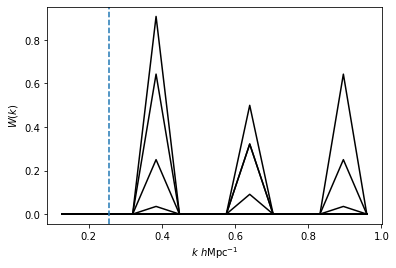

In [28]:
for ik in range(kbins.size):
    plt.plot(kbins.value,sph_wf[ik,:],color='k')
plt.axvline(kbins[2].value,ls='--')
plt.xlabel(r'$k~h\mathrm{Mpc}^{-1}$'); plt.ylabel(r'$W(k)$')

These are ugly because of the very restricted spectral window considered in the example ftfile.

### 4. Compute cylindrical window functions

It is also possible to compute the cylindrical window functions for a given baseline length:

In [29]:
# choose baseline
ib = 12

In [30]:
kperp, kpara, cyl_wf = uvw.get_cylindrical_wf(lens[ib], kperp_bins=None, kpara_bins=None, 
                                              return_bins='unweighted')

The $k_\perp$ and $k_\parallel$ bins used as a grid to compute these functions are returned simultaneously with the `return_bins` option. If the option is `return_bins='weighted'`, then we retrieve the $k_\perp$ and $k_\parallel$ bins weighted by the number of modes used to compute each value.

The resulting array is $W(b,\tau,k_\perp,k_\parallel)$ and has shape (Ndlys, Nkperp, Nkpara).

In [31]:
cyl_wf.shape

(20, 16, 18)

Text(0.5, 1.0, '$(b,\\tau)=(38.6 ~\\mathrm{m},2048 ~\\mathrm{ns})$')

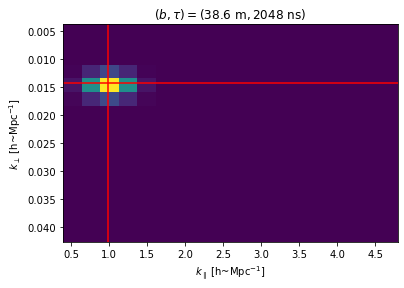

In [33]:
it = 6

plt.figure()
plt.imshow(cyl_wf[it,:,:],extent=(kpara.min(),kpara.max(),kperp.max(),kperp.min()),aspect='auto')
kpara_centre = cosmo.tau_to_kpara(uvw.avg_z,little_h=uvw.little_h)*abs(uvw.dly_array[it]) 
kperp_centre = cosmo.bl_to_kperp(uvw.avg_z,little_h=uvw.little_h)*lens[ib]
plt.axvline(kpara_centre,color='r');plt.axhline(kperp_centre,color='r')
plt.ylabel(r'$k_{\perp}$ [h~Mpc$^{-1}$]'); plt.xlabel(r'$k_{\parallel}$ [h~Mpc$^{-1}$]')
plt.title(r'$(b,\tau)=(%.1f ~\mathrm{m},%i ~\mathrm{ns})$' %(lens[ib],abs(uvw.dly_array[it])*1e9))

The cylindrical window functions can then be averaged to obtain the spherical ones:

In [35]:
# compute the gride of $k$ magnitudes covered by the array
ktot = np.sqrt(kperp[:, None]**2+kpara**2)
# and average
sph_wf2, _ = uvw.cylindrical_to_spherical(cyl_wf[None], kbins, ktot, bl_lens)

Some spherical bins are empty. Add baselines or expand spectral window.


We retrieve the same result as before:

Text(0, 0.5, '$W(k)$')

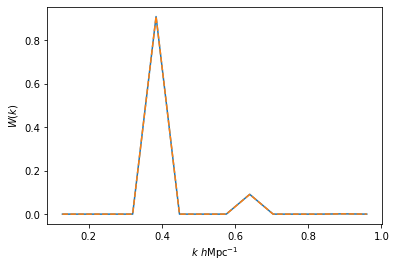

In [36]:
plt.plot(kbins.value,sph_wf[2,:])
plt.plot(kbins.value,sph_wf2[2,:],ls='--')
plt.xlabel(r'$k~h\mathrm{Mpc}^{-1}$'); plt.ylabel(r'$W(k)$')

## Other options

### Initialise UVWindow from UVPSpec object

Let's first obtain a `UVPSPec` object

Initialise UVData object

In [37]:
datafile = os.path.join(DATA_PATH, dfile)
uvd = UVData()
uvd.read_uvh5(datafile)

Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array.


Load beam

In [38]:
# List of beamfile to load. This is a healpix map.
beamfile = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
# intantiate beam and pass cosmology, if not fed, a default Planck cosmology will be assumed
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=None)
# find conversion factor from Jy to mK
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd.freq_array), pol=pol)
# reshape to appropriately match a UVData.data_array object and multiply in!
uvd.data_array *= Jy_to_mK[None, None, :, None]

Create data set to cross-correlate

In [39]:
# Create a new PSpecData object, and don't forget to feed the beam object
ds = hp.PSpecData(dsets=[uvd, uvd], wgts=[None, None], beam=uvb)

Choose parameters to compute the power spectrum:

In [40]:
baselines = [uvd.baseline_to_antnums(bl) for bl in [uvd.baseline_array[0]]]
baselines1, baselines2, blpairs = hp.utils.construct_blpairs(baselines,exclude_permutations=False)

In [41]:
uvp = ds.pspec(baselines1, baselines2, dsets=(0, 1), pols=[(pol, pol)], spw_ranges=(175,195), 
               taper='blackman-harris',verbose=False)

Casting complex values to real discards the imaginary part


Initialise `UVWindow` object from `uvp` -- the `FTBeam` object required to initialise `UVWindow` will be internally computed.

In [43]:
uvw_ps = UVWindow.from_uvpspec(uvp, ftfile=base_ftfile, ipol=0, spw=0,
                               x_orientation=uvd.x_orientation, verbose=True)

The properties of the `UVPSpec` object are parsed to the `UVWindow` object.

In [44]:
uvp.taper,uvw_ps.taper

('blackman-harris', 'blackman-harris')

In [45]:
uvp.polpair_array[0], uvw_ps.pols

(1515, ('xx', 'xx'))

Then, we can use the module functions as before:

In [46]:
sph_wf3,_=uvw_ps.get_spherical_wf(kbins,
                               kperp_bins=None,kpara_bins=None,
                               bl_lens = bl_lens,
                               return_weights = True,
                               verbose = True)

Computing for blg 1 of 1... 


Max spherical k probed is not included in bins.
Some spherical bins are empty. Add baselines or expand spectral window.


Text(0, 0.5, '$W(k)$')

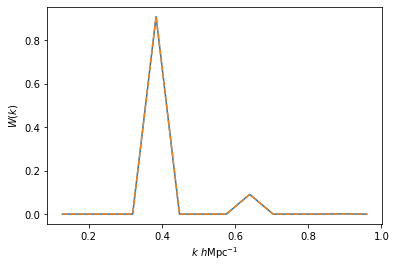

In [47]:
plt.plot(kbins.value,sph_wf[2,:])
plt.plot(kbins.value,sph_wf3[2,:],ls='--')
plt.xlabel(r'$k~h\mathrm{Mpc}^{-1}$'); plt.ylabel(r'$W(k)$')

### Compute cylindrical window functions and save

In [50]:
uvw = UVWindow(ftbeam_obj = ftbeam,
               taper = 'blackman-harris',
               cosmo=cosmo,
               little_h=little_h,
               verbose=True)

In [54]:
uvw.run_and_write(filepath=os.path.join(DATA_PATH, 'test.h5py'),
                  bl_lens = bl_lens,
                  kperp_bins=None,kpara_bins=None,
                  clobber=True)
print(os.path.isfile(os.path.join(DATA_PATH, 'test.h5py')))

True


In [55]:
os.remove(os.path.join(DATA_PATH, 'test.h5py'))